## **EXP3 Predicting Real Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP3 analysis and results. Files used were created in preprocessing/EXP3_pseudos notebook.*

*Note that the section part of this notebook compares different deconvolution methods, which need to be run before this file.*

**Summary:**
Using single nucleus and single cell RNA-seq datasets with real missing cell types.

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
from scipy.stats import kruskal
import scikit_posthocs as sph
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP3.py file and can be run through paperpill using run_EXP3.sh file.

In [2]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_adp_EXP3"
pseudo_name = "MCT_adp_EXP3"
files_path = "/../data/EXP3/"
path_results = "/../results/EXP3/"
data_path = "/../data/EXP3/cibersort/"
cibersort_files = "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/\
CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses.CIBERSORTx_\
MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
bulkprop_type = "random"
noise_type = "noise"
bulk_type = f"{bulkprop_type}prop_{noise_type}"
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
#and kernel environment
kerne_name = "env_ml"

In [3]:
#font for plots
font = {'fontname':'Arial'}

#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"
path_results = f"{actual_path}{path_results}"
data_path = f"{actual_path}{data_path}"

Import the previously processed datasets. 

*See preprocessing/EXP3_pseudos.ipynb notebook for details.*

In [4]:
#and as anndata object single nucleus 
adata_path = os.path.join(path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 116066 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [5]:
#and single cell
adata_path = os.path.join(path, f"{res_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
sc_adata

AnnData object with n_obs × n_vars = 18552 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [6]:
sc_prop = vp.make_prop_table(sc_adata, "cell_types")
sc_prop = sc_prop[:-1]
sc_prop.sort_values("Cell_Types")
sc_prop.reindex()
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop = sn_prop[:-1]
sn_prop.sort_values("Cell_Types")
sn_prop.reindex()
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,mesothelial cell,26276,0.226388
1,fat cell,24825,0.213887
2,macrophage,13625,0.117390
3,preadipocyte,26941,0.232118
4,endothelial cell,11480,0.098909
5,endothelial cell of lymphatic vessel,2339,0.020152
6,pericyte cell,1165,0.010037
7,T cell,3022,0.026037
8,smooth muscle cell,2457,0.021169
9,B cell,231,0.001990


In [7]:
sc_prop

,Cell_Types,Num_Cells,Prop_Cells
0,dendritic cell,983,0.052986
1,monocyte,636,0.034282
2,preadipocyte,13461,0.725582
3,endothelial cell of lymphatic vessel,157,0.008463
4,macrophage,1410,0.076003
5,T cell,807,0.043499
6,endothelial cell,542,0.029215
7,immature NK T cell,389,0.020968
8,B cell,36,0.001940
9,neutrophil,2,0.000108


In [8]:
#import the same proportions from bulks used in the other deconv. methods:
#real proportions
realprop_results_path = os.path.join(data_path, f"{res_name}_{bulk_type}_prop.txt")
realprop_results_path = Path(realprop_results_path)
# Open the CSV file in read mode
real_prop = pd.read_csv(realprop_results_path, sep="\t")
#index from CSV file
if "Unnamed: 0" in real_prop.columns:
    real_prop = real_prop.drop(columns="Unnamed: 0")
prop_df = real_prop
prop_df

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,0.0700,0.0338,0.0524,0.0696,0.0090,0.1066,0.1014,0.0446,0.3600,0.0372,0.0906,0.0248
1,0.1710,0.1270,0.0150,0.2110,0.0868,0.0422,0.0112,0.0196,0.1110,0.0278,0.1478,0.0296
2,0.0230,0.0376,0.0160,0.0286,0.1586,0.0402,0.2898,0.0118,0.1800,0.0922,0.0882,0.0340
3,0.1160,0.0088,0.0286,0.0296,0.0758,0.2162,0.0318,0.2152,0.0440,0.0620,0.0998,0.0722
4,0.0552,0.0208,0.0152,0.1002,0.1798,0.0660,0.2888,0.0444,0.1074,0.0324,0.0656,0.0242
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0116,0.4096,0.0652,0.1044,0.0088,0.0094,0.0230,0.0112,0.1008,0.1182,0.0378,0.1000
996,0.0502,0.0740,0.0304,0.0468,0.0028,0.0348,0.0488,0.1036,0.4048,0.0318,0.0790,0.0930
997,0.0242,0.0448,0.1436,0.0410,0.0586,0.0234,0.1166,0.0358,0.0528,0.0064,0.1392,0.3136
998,0.1250,0.0990,0.1410,0.0172,0.0988,0.0668,0.0468,0.1436,0.0342,0.0574,0.0898,0.0804


In [9]:
#matching cell-types from the other methods 
#that do not contain low-frequent cell-types
sn_prop = sn_prop[sn_prop['Cell_Types'].isin(prop_df.columns)]
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,mesothelial cell,26276,0.226388
1,fat cell,24825,0.213887
2,macrophage,13625,0.117390
3,preadipocyte,26941,0.232118
4,endothelial cell,11480,0.098909
5,endothelial cell of lymphatic vessel,2339,0.020152
6,pericyte cell,1165,0.010037
7,T cell,3022,0.026037
10,dendritic cell,679,0.005850
11,mast cell,883,0.007608


In [10]:
sc_prop = sc_prop[sc_prop['Cell_Types'].isin(prop_df.columns)]
sc_prop

,Cell_Types,Num_Cells,Prop_Cells
0,dendritic cell,983,0.052986
1,monocyte,636,0.034282
2,preadipocyte,13461,0.725582
3,endothelial cell of lymphatic vessel,157,0.008463
4,macrophage,1410,0.076003
5,T cell,807,0.043499
6,endothelial cell,542,0.029215
7,immature NK T cell,389,0.020968
11,pericyte cell,52,0.002803
13,mast cell,53,0.002857


In [11]:
# define the number of cells and the list of missing cell counts
num_cells_sn = len(sn_prop)
cell_order_sn = sn_prop["Cell_Types"].unique()

num_cells_sc = len(sc_prop)
cell_order_sc = sc_prop["Cell_Types"].unique()

In [12]:
# Filter Anndata objects based on cell types
sn_adata = sn_adata[sn_adata.obs['cell_types'].isin(sn_prop['Cell_Types'])]
sc_adata = sc_adata[sc_adata.obs['cell_types'].isin(sc_prop['Cell_Types'])]

# Display the resulting filtered Anndata objects
print(sn_adata)
print(sc_adata)

View of AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'
View of AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'


Cells Missing from Real Proportions:

In [13]:
cells_names = np.setdiff1d(sn_prop["Cell_Types"].values, sc_prop["Cell_Types"].values)
cells_to_miss_idx = list()
for cell in cells_names:
    cells_to_miss_idx.append(sn_prop.loc[sn_prop['Cell_Types'] == cell].index[0])
cells_to_miss_idx

num_missing_cells = [0, len(cells_to_miss_idx)]

In [14]:
cells_to_miss = dict()
cells_to_miss[0] = []
cells_to_miss[num_missing_cells[1]] = cells_to_miss_idx

Importing CIBERSORTx results for genes:

In [15]:
# read in cibersort genes 
gene_ids_sn = sn_adata.var_names
gene_ids_sc = sc_adata.var_names

gene_ids = np.intersect1d(gene_ids_sc, gene_ids_sn)
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

2752

Cut anndatas to gene_ids from CIBERSORTx:

In [16]:
gene_mask = sn_adata.var_names.isin(gene_ids)
# Then, filter the AnnData object using the mask
sn_adata = sn_adata[:, gene_mask]

gene_mask = sc_adata.var_names.isin(gene_ids)
# Then, filter the AnnData object using the mask
sc_adata = sc_adata[:, gene_mask]

## Creating reference profiles from single cell and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [17]:
# Making cell type reference without scaling
cell_types_sc = sc_adata.obs["cell_types"].unique()
gene_ids = sc_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types_sc)
for cell_type in cell_types_sc:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

,dendritic cell,monocyte,preadipocyte,endothelial cell of lymphatic vessel,macrophage,T cell,endothelial cell,immature NK T cell,pericyte cell,mast cell
gene_ids,,,,,,,,,,
AATF,1390.0,1906.0,1238.0,1996.0,2058.0,1163.0,1788.0,1975.0,1770.0,2493.0
ABAT,606.0,559.0,369.0,347.0,600.0,544.0,218.0,379.0,403.0,382.0
ABCA10,716.0,650.0,10212.0,658.0,500.0,760.0,914.0,1045.0,1134.0,564.0
ABCA8,841.0,802.0,10090.0,1897.0,797.0,736.0,603.0,850.0,2245.0,739.0
ABCA9,1639.0,1202.0,21438.0,996.0,947.0,1344.0,1300.0,1477.0,3817.0,361.0
...,...,...,...,...,...,...,...,...,...,...
ZNRF3,282.0,270.0,589.0,200.0,333.0,80.0,984.0,261.0,1756.0,0.0
ZSCAN31,27.0,40.0,51.0,0.0,83.0,0.0,138.0,54.0,390.0,0.0
ZSWIM5,824.0,560.0,774.0,1178.0,616.0,581.0,995.0,423.0,1229.0,496.0


In [18]:
# Making cell type reference without snaling
cell_types_sn = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw_sn = pd.DataFrame(index = gene_ids, columns = cell_types_sn)
for cell_type in cell_types_sn:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw_sn[cell_type] = sum_over_genes.values
ref_raw_sn

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
gene_ids,,,,,,,,,,,,
AATF,1824.0,3010.0,2742.0,1770.0,1898.0,1666.0,932.0,2253.0,2802.0,1436.0,3551.0,2553.0
ABAT,803.0,1563.0,2575.0,769.0,415.0,478.0,455.0,886.0,1853.0,744.0,2615.0,912.0
ABCA10,2227.0,15130.0,1100.0,55580.0,1581.0,1938.0,2490.0,1385.0,1606.0,1631.0,1532.0,1707.0
ABCA8,9900.0,16439.0,2396.0,30539.0,803.0,1188.0,8737.0,1123.0,1679.0,844.0,1136.0,802.0
ABCA9,1094.0,8371.0,15536.0,45253.0,888.0,1063.0,3579.0,1427.0,4728.0,1328.0,2270.0,1318.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,5941.0,5976.0,820.0,2226.0,1396.0,929.0,819.0,502.0,878.0,373.0,320.0,270.0
ZSCAN31,2915.0,800.0,304.0,794.0,1184.0,437.0,397.0,147.0,236.0,242.0,148.0,231.0
ZSWIM5,2706.0,2089.0,474.0,1764.0,1935.0,4551.0,1345.0,2261.0,636.0,599.0,449.0,1485.0


In [19]:
#clipping before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types_sc)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types_sc)
ref_df

,dendritic cell,monocyte,preadipocyte,endothelial cell of lymphatic vessel,macrophage,T cell,endothelial cell,immature NK T cell,pericyte cell,mast cell
gene_ids,,,,,,,,,,
AATF,0.326513,0.447723,0.290808,0.468864,0.483428,0.273191,0.420004,0.463931,0.415776,0.585610
ABAT,0.142350,0.131310,0.086679,0.081511,0.140941,0.127787,0.051209,0.089028,0.094665,0.089732
ABCA10,0.168190,0.152686,1.000000,0.154565,0.117451,0.178525,0.214700,0.245472,0.266379,0.132485
ABCA8,0.197552,0.188391,1.000000,0.445608,0.187217,0.172888,0.141646,0.199666,0.527354,0.173592
ABCA9,0.385004,0.282352,1.000000,0.233962,0.222452,0.315708,0.305372,0.346950,0.896620,0.084800
...,...,...,...,...,...,...,...,...,...,...
ZNRF3,0.066242,0.063423,0.138357,0.046980,0.078222,0.018792,0.231143,0.061309,0.412487,0.000000
ZSCAN31,0.006342,0.009396,0.011980,0.000000,0.019497,0.000000,0.032416,0.012685,0.091612,0.000000
ZSWIM5,0.193559,0.131545,0.181814,0.276714,0.144699,0.136478,0.233727,0.099363,0.288694,0.116511


In [20]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_sn.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df_sn = scaler.transform(ref_raw_val)
ref_df_sn = pd.DataFrame(ref_df_sn, index = gene_ids, columns = cell_types_sn)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types_sn)
ref_df_sn

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
gene_ids,,,,,,,,,,,,
AATF,0.292201,0.482383,0.439434,0.283201,0.303839,0.266994,0.149363,0.361066,0.449049,0.230134,0.569084,0.409144
ABAT,0.128549,0.250487,0.412670,0.122678,0.066059,0.076604,0.072918,0.141991,0.296962,0.119234,0.419081,0.146157
ABCA10,0.356797,1.000000,0.176286,1.000000,0.253012,0.310584,0.399048,0.221960,0.257378,0.261384,0.245519,0.273564
ABCA8,1.000000,1.000000,0.383984,1.000000,0.128270,0.190389,1.000000,0.179972,0.269077,0.135260,0.182056,0.128529
ABCA9,0.175193,1.000000,1.000000,1.000000,0.141899,0.170357,0.573571,0.228691,0.757711,0.212826,0.363791,0.211223
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF3,0.952098,0.957715,0.131413,0.356327,0.223350,0.148882,0.131253,0.080451,0.140709,0.059777,0.051283,0.043270
ZSCAN31,0.467073,0.128208,0.048719,0.126687,0.189358,0.070034,0.063623,0.023558,0.037821,0.038783,0.023719,0.037020
ZSWIM5,0.433573,0.334784,0.075963,0.282239,0.309772,0.729344,0.215550,0.362348,0.101926,0.095996,0.071957,0.237986


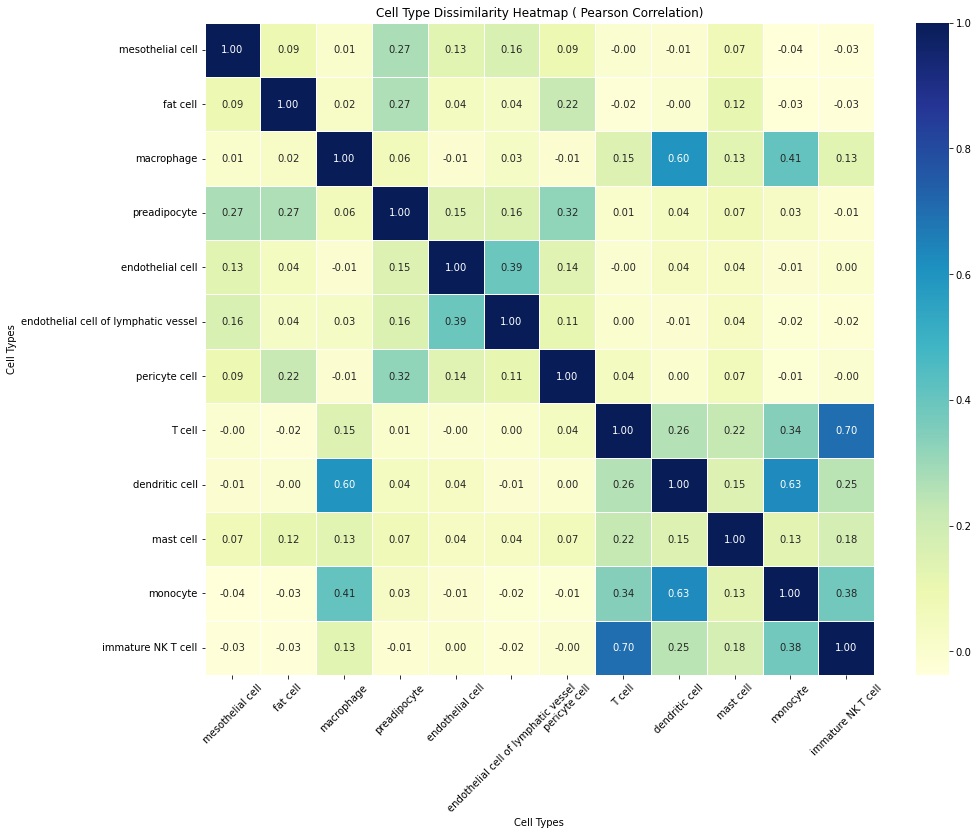

In [21]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

Importing Bulks:

Using the same bulk for all three deconv. methods:

In [22]:
pseudo_path = os.path.join(data_path, f"{res_name}_{bulk_type}_mixture.txt")
pseudo_path = Path(pseudo_path)
# Open the CSV file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep="\t")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
pseudo_df = pseudo_df.T
pseudo_df_copy = pseudo_df.copy()
pseudo_df.columns = pseudo_df.loc["gene_ids"].values
pseudo_df = pseudo_df.drop(labels='gene_ids')
pseudo_df = pseudo_df[gene_ids]
pseudo_df

,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,924932.797833,569290.970239,7276819.236504,4808055.890933,10599205.216525,57810.369297,365042.208478,428169.376099,1008438.225203,3092700.805764,...,138767.888064,515403.029259,144380.588424,1475960.211323,442963.840971,436671.184061,47172.298653,481061.92879,393632.824766,156429625.436873
1,1510526.062377,360198.960237,58643034.428344,25459622.55451,46627570.724145,308865.112782,619909.868265,319183.249356,774223.959474,1488797.695612,...,359297.368214,1051190.721316,41344.158844,1263442.991795,967554.299577,1789260.35988,285819.082161,1038099.936495,830507.576496,190846493.902625
2,1315469.425992,354497.952454,4473486.23271,8987318.772724,5278880.450797,489387.882623,388180.784982,118648.445145,2801346.889692,1910777.276503,...,243731.771887,481687.579998,53296.222436,1336088.660866,1516954.104714,513370.281282,93959.698612,394216.407773,516075.141204,158816895.102287
3,972005.493825,213408.467339,2492212.711349,2547854.155865,2216775.235293,452665.769421,227928.177308,89914.32753,593899.204541,1094536.970107,...,150266.285616,675919.667945,1584110.387468,802166.332722,592624.831592,428711.699665,93955.893526,831196.058675,381198.247184,125367391.547715
4,634350.908152,190417.517635,12330325.917963,12086011.376369,14789789.313707,505253.568586,377127.463363,135757.808258,1493620.161301,988393.745872,...,133937.284372,547076.66389,145655.692798,696464.412918,910985.641673,491947.231378,130959.612027,471294.009995,542609.102934,148453555.235744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1593834.478446,370270.961479,42553346.717871,27631510.882789,24576731.909046,137167.062486,1112226.247664,395947.419861,499615.721313,2414395.081494,...,345134.059315,3893291.917558,105137.597913,1289440.625767,1478993.441911,2098374.923811,65264.111304,611118.040031,974266.362303,315595739.953952
996,1815365.538522,932479.024507,8189752.495066,5284402.591602,10888672.805466,288602.792833,1125702.555524,641901.263473,1637087.687743,3248081.106715,...,256563.487291,978737.361559,652353.239411,2391659.131986,924220.020943,631623.865714,45604.88801,600542.117096,1211892.855396,207695922.419984
997,1208253.789119,224847.862097,3068884.832031,3627898.180387,8789315.580545,750099.405763,609042.489979,359129.616406,655195.488701,2326114.979011,...,286780.0743,561214.884438,736615.628643,721637.700674,323317.686862,285747.271516,27507.364929,488638.929124,401646.896138,76692822.644436
998,1085209.724643,265082.730406,3731031.066607,3761619.689692,7928957.762075,647376.818045,501093.132965,236861.153725,1029142.964389,2148888.133148,...,262039.386796,694950.396416,456834.120199,1061874.08249,1271211.142731,564253.118383,139156.406135,931683.898421,420511.700976,187828698.849772


In [23]:
#matching index 
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
pseudo_df

,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,924932.797833,569290.970239,7276819.236504,4808055.890933,10599205.216525,57810.369297,365042.208478,428169.376099,1008438.225203,3092700.805764,...,138767.888064,515403.029259,144380.588424,1475960.211323,442963.840971,436671.184061,47172.298653,481061.92879,393632.824766,156429625.436873
1,1510526.062377,360198.960237,58643034.428344,25459622.55451,46627570.724145,308865.112782,619909.868265,319183.249356,774223.959474,1488797.695612,...,359297.368214,1051190.721316,41344.158844,1263442.991795,967554.299577,1789260.35988,285819.082161,1038099.936495,830507.576496,190846493.902625
2,1315469.425992,354497.952454,4473486.23271,8987318.772724,5278880.450797,489387.882623,388180.784982,118648.445145,2801346.889692,1910777.276503,...,243731.771887,481687.579998,53296.222436,1336088.660866,1516954.104714,513370.281282,93959.698612,394216.407773,516075.141204,158816895.102287
3,972005.493825,213408.467339,2492212.711349,2547854.155865,2216775.235293,452665.769421,227928.177308,89914.32753,593899.204541,1094536.970107,...,150266.285616,675919.667945,1584110.387468,802166.332722,592624.831592,428711.699665,93955.893526,831196.058675,381198.247184,125367391.547715
4,634350.908152,190417.517635,12330325.917963,12086011.376369,14789789.313707,505253.568586,377127.463363,135757.808258,1493620.161301,988393.745872,...,133937.284372,547076.66389,145655.692798,696464.412918,910985.641673,491947.231378,130959.612027,471294.009995,542609.102934,148453555.235744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1593834.478446,370270.961479,42553346.717871,27631510.882789,24576731.909046,137167.062486,1112226.247664,395947.419861,499615.721313,2414395.081494,...,345134.059315,3893291.917558,105137.597913,1289440.625767,1478993.441911,2098374.923811,65264.111304,611118.040031,974266.362303,315595739.953952
996,1815365.538522,932479.024507,8189752.495066,5284402.591602,10888672.805466,288602.792833,1125702.555524,641901.263473,1637087.687743,3248081.106715,...,256563.487291,978737.361559,652353.239411,2391659.131986,924220.020943,631623.865714,45604.88801,600542.117096,1211892.855396,207695922.419984
997,1208253.789119,224847.862097,3068884.832031,3627898.180387,8789315.580545,750099.405763,609042.489979,359129.616406,655195.488701,2326114.979011,...,286780.0743,561214.884438,736615.628643,721637.700674,323317.686862,285747.271516,27507.364929,488638.929124,401646.896138,76692822.644436
998,1085209.724643,265082.730406,3731031.066607,3761619.689692,7928957.762075,647376.818045,501093.132965,236861.153725,1029142.964389,2148888.133148,...,262039.386796,694950.396416,456834.120199,1061874.08249,1271211.142731,564253.118383,139156.406135,931683.898421,420511.700976,187828698.849772


In [24]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,0.157419,0.334909,1.000000,0.699823,1.000000,0.010482,0.168631,0.169565,0.140017,0.441263,...,0.126065,0.070312,0.020788,0.332971,0.038301,0.063978,0.029204,0.083909,0.108840,0.0
1,0.335189,0.195439,1.000000,1.000000,1.000000,0.073389,0.324100,0.125745,0.102724,0.178763,...,0.494939,0.153453,0.004929,0.276968,0.121501,0.298697,0.265287,0.212751,0.327287,0.0
2,0.275975,0.191637,0.654376,1.000000,0.784772,0.118622,0.182746,0.045115,0.425490,0.247826,...,0.301635,0.065081,0.006769,0.296112,0.208636,0.077288,0.075488,0.063821,0.170064,0.0
3,0.171709,0.097526,0.317572,0.300395,0.247980,0.109421,0.084992,0.033561,0.074012,0.114237,...,0.145298,0.095221,0.242376,0.155411,0.062037,0.062597,0.075485,0.164894,0.102623,0.0
4,0.069206,0.082191,1.000000,1.000000,1.000000,0.122598,0.176003,0.051994,0.217269,0.096866,...,0.117985,0.075227,0.020984,0.127556,0.112529,0.073571,0.112091,0.081649,0.183331,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.360479,0.202158,1.000000,1.000000,1.000000,0.030366,0.624412,0.156610,0.059000,0.330250,...,0.471249,0.594475,0.014748,0.283819,0.202616,0.352339,0.047101,0.113990,0.399169,0.0
996,0.427730,0.577166,1.000000,0.784004,1.000000,0.068312,0.632632,0.255502,0.240113,0.466694,...,0.323099,0.142210,0.098969,0.574279,0.114628,0.097809,0.027653,0.111544,0.517987,0.0
997,0.243427,0.105157,0.415603,0.491263,1.000000,0.183949,0.317471,0.141806,0.083772,0.315801,...,0.373641,0.077421,0.111938,0.134190,0.019325,0.037788,0.009750,0.085661,0.112847,0.0
998,0.206074,0.131994,0.528163,0.514894,1.000000,0.158209,0.251622,0.092645,0.143313,0.286796,...,0.332258,0.098174,0.068877,0.223850,0.169661,0.086118,0.120200,0.188137,0.122280,0.0


In [25]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,0.157419,0.334909,1.000000,0.699823,1.000000,0.010482,0.168631,0.169565,0.140017,0.441263,...,0.126065,0.070312,0.020788,0.332971,0.038301,0.063978,0.029204,0.083909,0.108840,0.0
1,0.335189,0.195439,1.000000,1.000000,1.000000,0.073389,0.324100,0.125745,0.102724,0.178763,...,0.494939,0.153453,0.004929,0.276968,0.121501,0.298697,0.265287,0.212751,0.327287,0.0
2,0.275975,0.191637,0.654376,1.000000,0.784772,0.118622,0.182746,0.045115,0.425490,0.247826,...,0.301635,0.065081,0.006769,0.296112,0.208636,0.077288,0.075488,0.063821,0.170064,0.0
3,0.171709,0.097526,0.317572,0.300395,0.247980,0.109421,0.084992,0.033561,0.074012,0.114237,...,0.145298,0.095221,0.242376,0.155411,0.062037,0.062597,0.075485,0.164894,0.102623,0.0
4,0.069206,0.082191,1.000000,1.000000,1.000000,0.122598,0.176003,0.051994,0.217269,0.096866,...,0.117985,0.075227,0.020984,0.127556,0.112529,0.073571,0.112091,0.081649,0.183331,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.360479,0.202158,1.000000,1.000000,1.000000,0.030366,0.624412,0.156610,0.059000,0.330250,...,0.471249,0.594475,0.014748,0.283819,0.202616,0.352339,0.047101,0.113990,0.399169,0.0
996,0.427730,0.577166,1.000000,0.784004,1.000000,0.068312,0.632632,0.255502,0.240113,0.466694,...,0.323099,0.142210,0.098969,0.574279,0.114628,0.097809,0.027653,0.111544,0.517987,0.0
997,0.243427,0.105157,0.415603,0.491263,1.000000,0.183949,0.317471,0.141806,0.083772,0.315801,...,0.373641,0.077421,0.111938,0.134190,0.019325,0.037788,0.009750,0.085661,0.112847,0.0
998,0.206074,0.131994,0.528163,0.514894,1.000000,0.158209,0.251622,0.092645,0.143313,0.286796,...,0.332258,0.098174,0.068877,0.223850,0.169661,0.086118,0.120200,0.188137,0.122280,0.0


TSNEs of Pseuboulks and References: We expect the point of the References (cells) to be in separated within the pseudobulks encoding.

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.59 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...
Iteration   50, KL divergence 1.2770, 50 iterations in 0.5151 sec
Iteration  100, KL divergence 1.2560, 50 iterations in 0.4167 sec
Iteration  150, KL divergence 1.2515, 50 iterations in 0.4155 sec
Iteration  200, KL divergence 1.2478, 50 iterations in 0.4156 sec
Iteration  250, KL divergence 1.2465, 50 iterations in 0.4158 sec
Iteration  300, KL divergence 1.2458, 50 iterations in 0.4151 sec
Iteration  350, KL divergence 1.2458, 50 iterations in 0.4146 sec
Iteration  400, KL divergence 1.2449, 50 iterations in 0.4145 sec
Iteration  450, KL divergence 1.2444, 50 iterations in 0.4159 sec
Iteration  500, KL divergence 1.2440, 50 iterations in 0.4152 sec
   --> Time elapsed: 4.25 seconds
===> Finding 15 nearest n

Perplexity value 60 is too high. Using perplexity 3.00 instead


Iteration  250, KL divergence 47.0679, 50 iterations in 0.0110 sec
   --> Time elapsed: 0.05 seconds
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=10.00 for 500 iterations...
Iteration   50, KL divergence 0.0158, 50 iterations in 0.5764 sec
Iteration  100, KL divergence 0.0151, 50 iterations in 0.3925 sec
Iteration  150, KL divergence 0.0143, 50 iterations in 0.3917 sec
Iteration  200, KL divergence 0.0172, 50 iterations in 0.3925 sec
Iteration  250, KL divergence 0.0163, 50 iterations in 0.3919 sec
Iteration  300, KL divergence 0.0161, 50 iterations in 0.3920 sec
Iteration  350, KL divergence 0.0157, 50 iterations in 0.3922 sec
Iteration  400, KL divergence 0.0160, 50 iterations in 0.3921 sec
Iteration  450, KL divergence 0.0182, 50 iterations in 0.3920 sec
Iteration  500, KL divergence 0.0168, 50

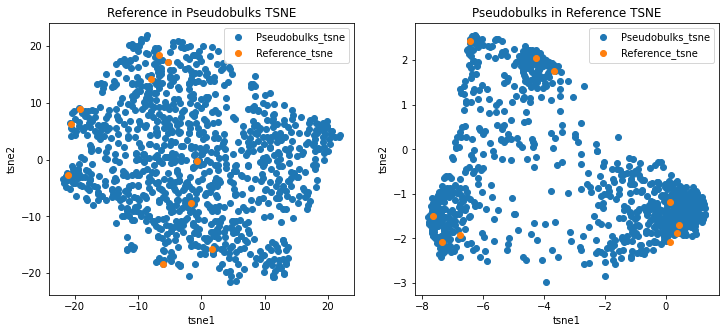

In [26]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

In [27]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df_sn
all_refs_raw[0] = ref_raw_sn
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df

#dropping cell types missing from references
for num in num_missing_cells[1:]:
    all_refs[num] = ref_df #.drop(ref_df.columns[cells_names], axis=1)
    all_refs_raw[num] = ref_raw #.drop(ref_raw.columns[cells_names], axis=1)
    all_prop_refs[num] = prop_df #.drop(prop_df.columns[cells_names], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num].drop(cells_names, axis=1) 
#rebalancing proportions with the missing cell types
all_prop_refs_rebalanced[2] = all_prop_refs_rebalanced[2].div(all_prop_refs_rebalanced[2].sum(axis=1), axis=0)
all_prop_refs_rebalanced[2]

,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
0,0.058469,0.077661,0.010042,0.118947,0.113144,0.049766,0.401696,0.041509,0.101094,0.027672
1,0.021368,0.300570,0.123647,0.060114,0.015954,0.027920,0.158120,0.039601,0.210541,0.042165
2,0.017032,0.030445,0.168831,0.042793,0.308495,0.012561,0.191612,0.098148,0.093890,0.036193
3,0.032678,0.033821,0.086609,0.247029,0.036335,0.245887,0.050274,0.070841,0.114031,0.082495
4,0.016450,0.108442,0.194589,0.071429,0.312554,0.048052,0.116234,0.035065,0.070996,0.026190
...,...,...,...,...,...,...,...,...,...,...
995,0.112647,0.180373,0.015204,0.016240,0.039737,0.019350,0.174153,0.204216,0.065308,0.172771
996,0.034711,0.053437,0.003197,0.039735,0.055720,0.118292,0.462206,0.036310,0.090203,0.106189
997,0.154243,0.044039,0.062943,0.025134,0.125242,0.038453,0.056713,0.006874,0.149517,0.336842
998,0.181701,0.022165,0.127320,0.086082,0.060309,0.185052,0.044072,0.073969,0.115722,0.103608


## NNLS Deconvolution:

In [28]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0
Exp 2


Ordering order of cells:

In [29]:
for num in num_missing_cells:
    calc_prop_tot[num] = calc_prop_tot[num].reindex(sorted(calc_prop_tot[num].columns), axis=1)
    all_prop_refs_rebalanced[num] = all_prop_refs_rebalanced[num].reindex(sorted(all_prop_refs_rebalanced[num].columns), axis=1)
all_prop_refs_rebalanced[0]

,T cell,dendritic cell,endothelial cell,endothelial cell of lymphatic vessel,fat cell,immature NK T cell,macrophage,mast cell,mesothelial cell,monocyte,pericyte cell,preadipocyte
0,0.0446,0.3600,0.0090,0.1066,0.0338,0.0248,0.0524,0.0372,0.0700,0.0906,0.1014,0.0696
1,0.0196,0.1110,0.0868,0.0422,0.1270,0.0296,0.0150,0.0278,0.1710,0.1478,0.0112,0.2110
2,0.0118,0.1800,0.1586,0.0402,0.0376,0.0340,0.0160,0.0922,0.0230,0.0882,0.2898,0.0286
3,0.2152,0.0440,0.0758,0.2162,0.0088,0.0722,0.0286,0.0620,0.1160,0.0998,0.0318,0.0296
4,0.0444,0.1074,0.1798,0.0660,0.0208,0.0242,0.0152,0.0324,0.0552,0.0656,0.2888,0.1002
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0112,0.1008,0.0088,0.0094,0.4096,0.1000,0.0652,0.1182,0.0116,0.0378,0.0230,0.1044
996,0.1036,0.4048,0.0028,0.0348,0.0740,0.0930,0.0304,0.0318,0.0502,0.0790,0.0488,0.0468
997,0.0358,0.0528,0.0586,0.0234,0.0448,0.3136,0.1436,0.0064,0.0242,0.1392,0.1166,0.0410
998,0.1436,0.0342,0.0988,0.0668,0.0990,0.0804,0.1410,0.0574,0.1250,0.0898,0.0468,0.0172


Evalutating NNLS Performance:

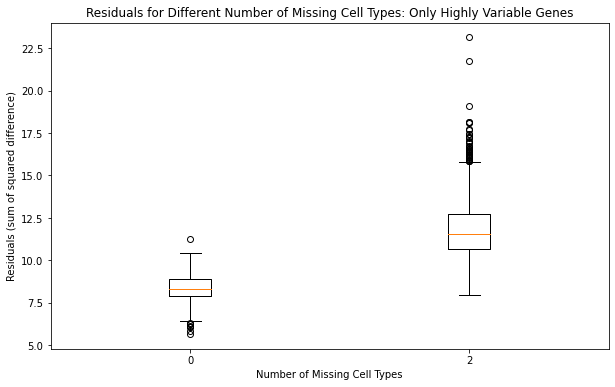

In [30]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

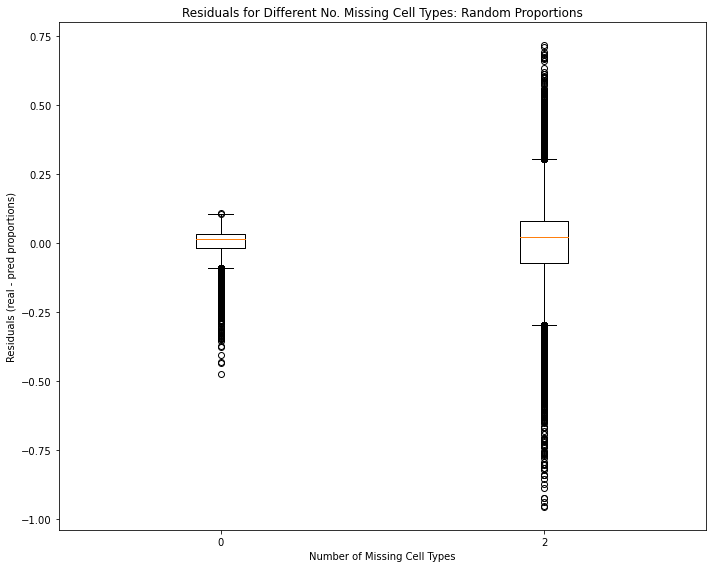

In [31]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

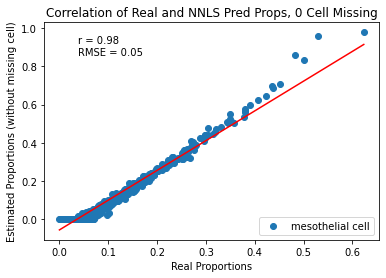

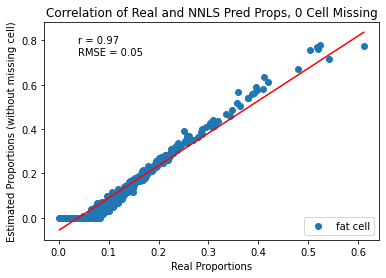

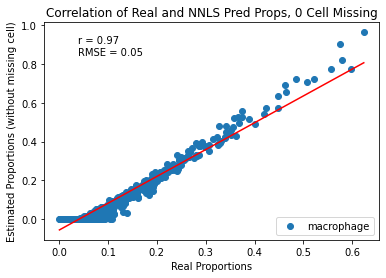

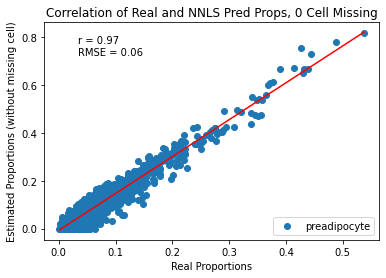

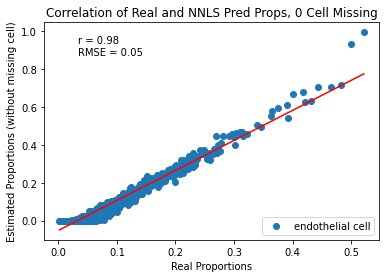

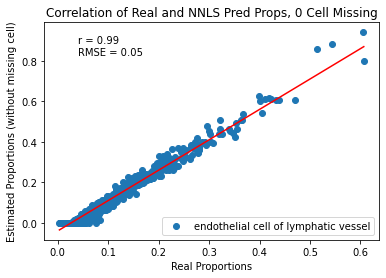

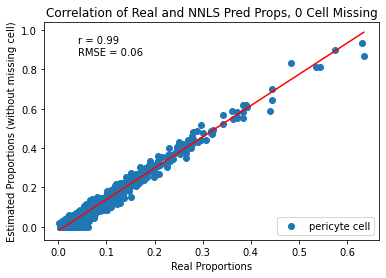

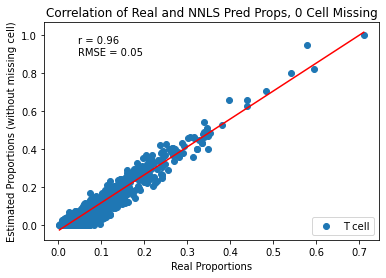

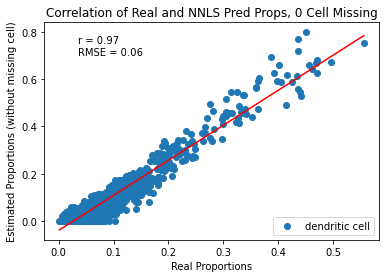

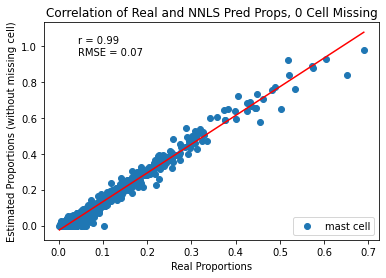

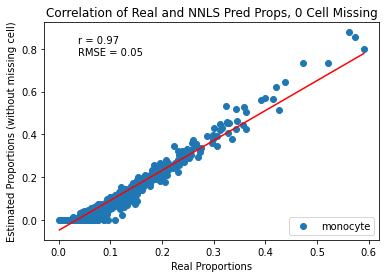

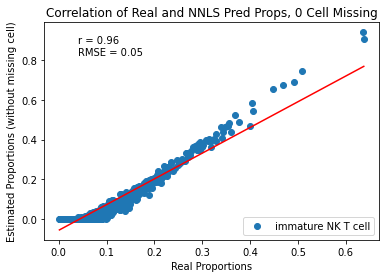

In [32]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    # Calculate RMSE
    rmse = np.sqrt(((x - y) ** 2).mean())
    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='lower right')
    plt.show()

Real Proportions shape: (1000, 12)
Estimated Proportions shape: (1000, 12)


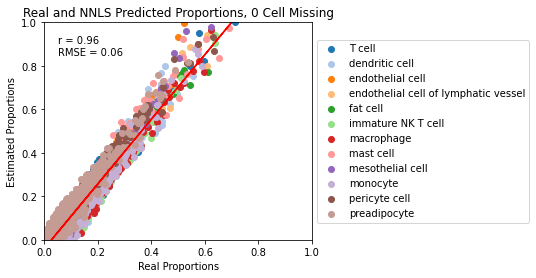

Real Proportions shape: (1000, 10)
Estimated Proportions shape: (1000, 10)


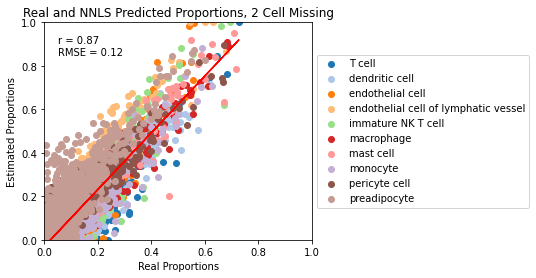

In [33]:
#Comparnig performance for all cell types with num_cells_missing.
# define colormap for coloring cell types
cmap = get_cmap('tab20') 

# Create a dictionary to store color mapping for each cell type
cell_type_colors = {}
for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float) #real proportions of present cells
    estimated_proportions = calc_prop_tot[num].values.astype(float) #estimated proportions of present cells.
    cell_types = all_prop_refs_rebalanced[num].columns.tolist() 
    
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]

    # Scatter plot with colored points for each cell type
    fig, ax = plt.subplots()

    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]

        # Check if the cell type already has a color assigned
        if cell_type not in cell_type_colors:
            # Assign a unique color for each cell type
            color = cmap(len(cell_type_colors))
            cell_type_colors[cell_type] = color
        else:
            color = cell_type_colors[cell_type]

        ax.scatter(x, y, label=cell_type, color=color)

    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")

    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())

    # Calculate RMSE
    rmse = np.sqrt(((x - y) ** 2).mean())

    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')   
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions')
    plt.title(f'Real and NNLS Predicted Proportions, {num} Cell Missing')

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    max_val = max([real_proportions.max(), estimated_proportions.max()])
    if bulkprop_type == "realistic":
        ax.set_xlim(0,max_val+.03)
        ax.set_ylim(0,max_val+.03)
    else:    
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
    plt.show()

And save results:

In [34]:
# Iterate through num_missing_cells
real_df = pd.DataFrame()
predicted_df = pd.DataFrame()

for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float)
    estimated_proportions = calc_prop_tot[num].values.astype(float)
    cell_types = all_prop_refs_rebalanced[num].columns.tolist()

    # Create dataframes
    real_df_current = pd.DataFrame(data=real_proportions, columns=cell_types, index=[num]*len(real_proportions))
    predicted_df_current = pd.DataFrame(data=estimated_proportions, columns=cell_types, index=[num]*len(estimated_proportions))

    real_df = pd.concat([real_df, real_df_current])
    predicted_df = pd.concat([predicted_df, predicted_df_current])

# Save dataframes to .txt files
real_filename = f"{path_results}EXP3_NNLS_adp_{bulkprop_type}_{noise_type}_real.txt"
predicted_filename = f"{path_results}EXP3_NNLS_adp_{bulkprop_type}_{noise_type}_predicted.txt"

# Save dataframes to .txt files
with open(real_filename, 'w') as file:
    real_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

with open(predicted_filename, 'w') as file:
    predicted_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

Recreate Matrices:

In [35]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,0.371159,0.224764,0.384524,0.467259,0.678657,0.038418,0.246378,0.201633,0.446581,0.620712,...,0.153619,0.190604,0.082295,0.540194,0.245701,0.182885,0.065123,0.200528,0.246726,1.0
1,0.367354,0.196359,0.605785,0.727890,0.623307,0.171227,0.252610,0.175127,0.292184,0.383932,...,0.159241,0.336963,0.010420,0.372352,0.292801,0.464390,0.176463,0.269189,0.273908,1.0
2,0.273658,0.140305,0.317351,0.535681,0.465114,0.242491,0.207007,0.105425,0.466813,0.329551,...,0.123887,0.132969,0.016105,0.291922,0.372468,0.140247,0.080589,0.192987,0.189301,1.0
3,0.315697,0.125140,0.285718,0.293366,0.221250,0.183695,0.168215,0.046326,0.242827,0.253348,...,0.126542,0.322155,0.606730,0.220553,0.309700,0.207448,0.099664,0.455541,0.199675,1.0
4,0.245289,0.107743,0.414353,0.669616,0.504283,0.261932,0.208357,0.064618,0.354603,0.275456,...,0.118144,0.178331,0.049611,0.249213,0.335380,0.176383,0.096989,0.253963,0.183106,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.422465,0.221916,0.742090,0.715239,0.797737,0.101649,0.349550,0.250400,0.248968,0.357357,...,0.226293,0.654275,0.064175,0.368746,0.455341,0.611454,0.096561,0.258043,0.391975,1.0
996,0.404251,0.237104,0.349978,0.393033,0.650632,0.091824,0.250944,0.208080,0.468620,0.616152,...,0.168538,0.242084,0.186615,0.535084,0.206401,0.193809,0.057800,0.182347,0.243669,1.0
997,0.374365,0.201986,0.306457,0.374303,0.459003,0.251294,0.202610,0.161328,0.254612,0.364404,...,0.172510,0.227575,0.365565,0.283717,0.163652,0.097322,0.049918,0.195606,0.206638,1.0
998,0.338320,0.179071,0.369585,0.478587,0.470075,0.195409,0.206182,0.139620,0.341419,0.378271,...,0.143132,0.282455,0.269738,0.312759,0.318303,0.289712,0.117226,0.286143,0.233542,1.0


## **Extracting Missing Cell Information:**

In [36]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

Residual uses:

Pseudobulks - [Calculated_Proportions * Reference]


In [37]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8,XIST
0,-0.213741,0.110145,0.615476,0.232564,0.321343,-0.027936,-0.077746,-0.032068,-0.306564,-0.179449,...,-0.027555,-0.120291,-0.061507,-0.207223,-0.207400,-0.118907,-0.035919,-0.116620,-0.137885,-1.0
1,-0.032165,-0.000920,0.394215,0.272110,0.376693,-0.097838,0.071490,-0.049383,-0.189460,-0.205168,...,0.335698,-0.183509,-0.005490,-0.095384,-0.171300,-0.165692,0.088824,-0.056439,0.053378,-1.0
2,0.002317,0.051331,0.337026,0.464319,0.319659,-0.123869,-0.024262,-0.060310,-0.041323,-0.081725,...,0.177748,-0.067888,-0.009336,0.004189,-0.163832,-0.062959,-0.005101,-0.129166,-0.019237,-1.0
3,-0.143989,-0.027614,0.031854,0.007029,0.026730,-0.074274,-0.083223,-0.012765,-0.168815,-0.139110,...,0.018756,-0.226934,-0.364355,-0.065142,-0.247662,-0.144851,-0.024179,-0.290647,-0.097052,-1.0
4,-0.176083,-0.025552,0.585647,0.330384,0.495717,-0.139334,-0.032354,-0.012624,-0.137334,-0.178591,...,-0.000159,-0.103104,-0.028627,-0.121657,-0.222850,-0.102812,0.015102,-0.172314,0.000226,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.061986,-0.019758,0.257910,0.284761,0.202263,-0.071282,0.274861,-0.093790,-0.189968,-0.027107,...,0.244956,-0.059800,-0.049427,-0.084928,-0.252725,-0.259115,-0.049460,-0.144053,0.007194,-1.0
996,0.023479,0.340062,0.650022,0.390971,0.349368,-0.023512,0.381688,0.047422,-0.228507,-0.149459,...,0.154561,-0.099874,-0.087646,0.039194,-0.091773,-0.096000,-0.030146,-0.070803,0.274319,-1.0
997,-0.130938,-0.096829,0.109146,0.116960,0.540997,-0.067345,0.114860,-0.019521,-0.170840,-0.048602,...,0.201132,-0.150154,-0.253627,-0.149527,-0.144327,-0.059534,-0.040168,-0.109945,-0.093791,-1.0
998,-0.132245,-0.047077,0.158579,0.036307,0.529925,-0.037200,0.045439,-0.046975,-0.198105,-0.091475,...,0.189126,-0.184281,-0.200861,-0.088909,-0.148642,-0.203594,0.002974,-0.098006,-0.111262,-1.0


Only show RMSE value if the proportions are random:


In [38]:
if bulkprop_type == "random":
    rmse_plot = True
else:
    rmse_plot = False    

## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [39]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [40]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

S-Value Eval for each SVD:

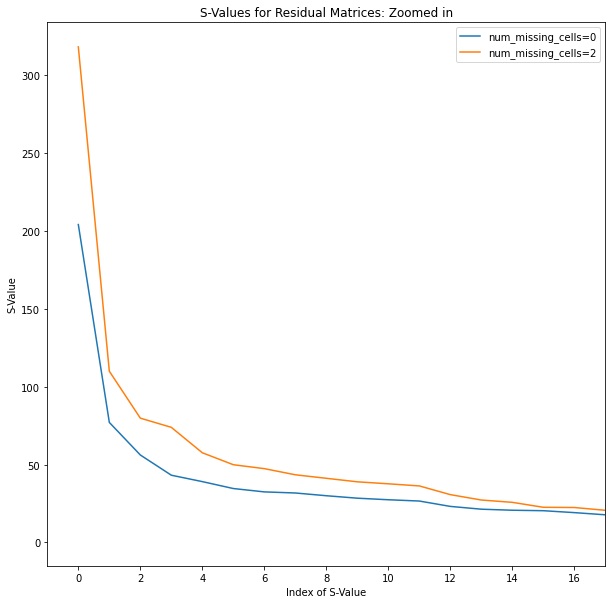

In [41]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [42]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


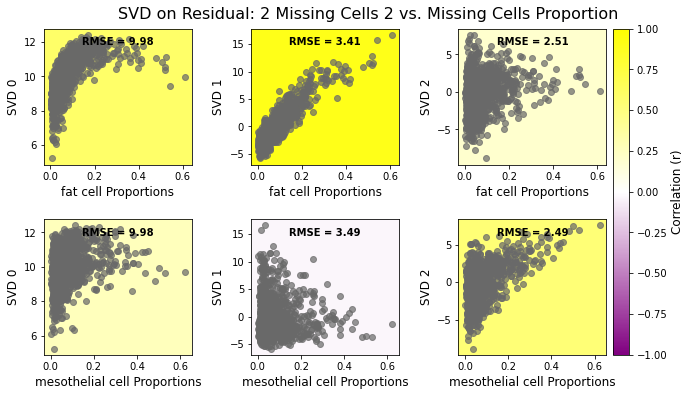

In [43]:
#SVD Residual(by sample) compared to each missing celltype proportion
vp.factors_vs_proportions_heatmaps_real(Recon_Mat_matchS, missing_cell_prop, 2, "SVD", rmse_plot)
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

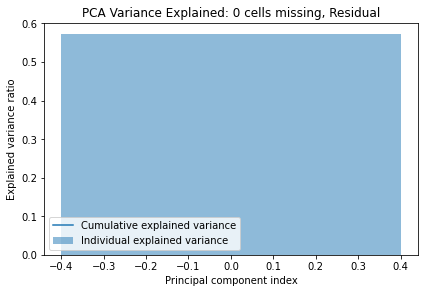

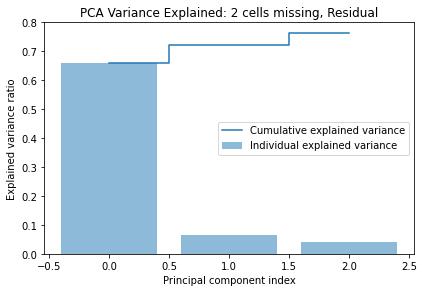

In [44]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

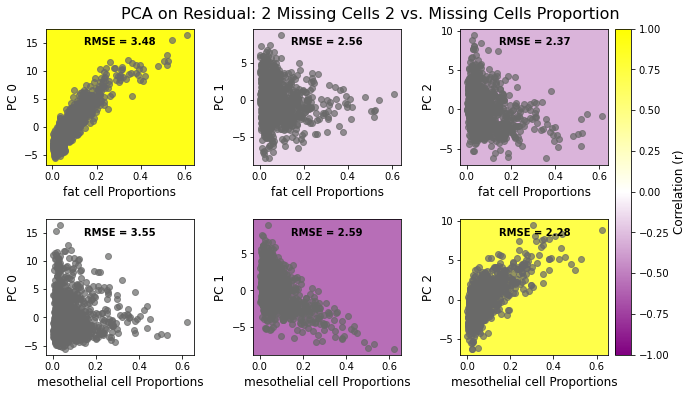

In [45]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_heatmaps_real(res_pca_sample, missing_cell_prop, 2, "PCA", rmse_plot)

## **ICA**

Calculate ICA

In [46]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

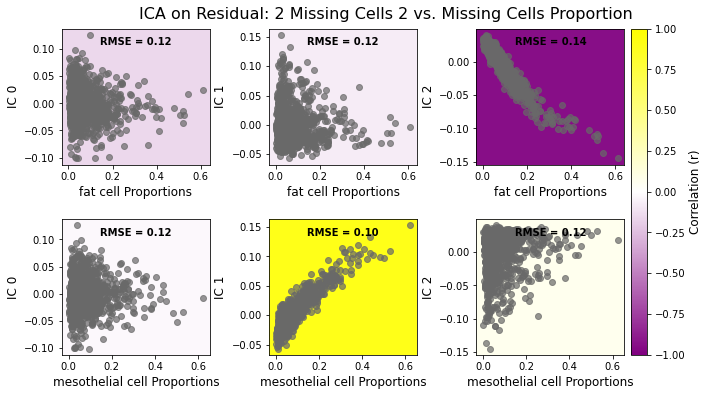

In [47]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_heatmaps_real(res_ICA_sample, missing_cell_prop, 2, "ICA", rmse_plot)

## NMF

Analyzing how close to negative the distributions of each residual are:

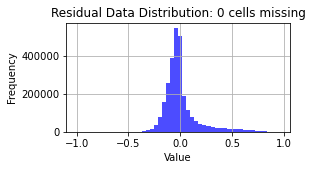

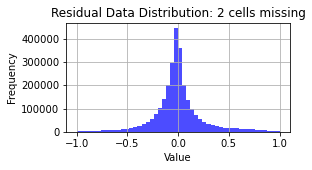

In [48]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000004


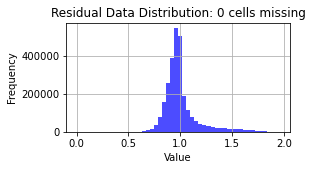

1.0000000000000004


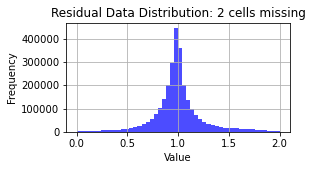

In [49]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Analyzing NMF Results:

Residual

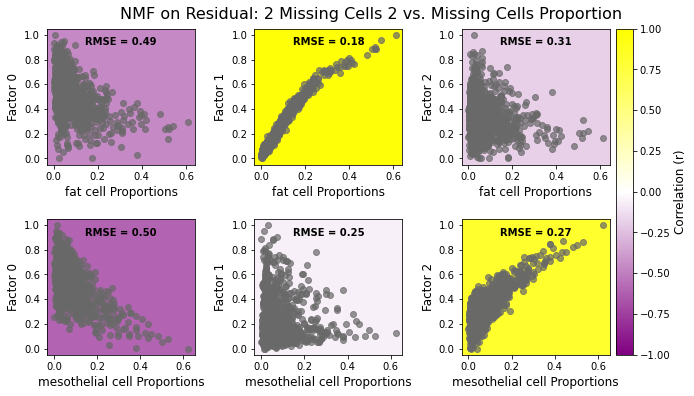

In [50]:
#if proportions are random and RMSE is significant:
if rmse_plot:
    #NMF Residual(by sample) compared to each missing celltype proportion
    res_nmf = dict()
    for num in num_missing_cells:
        num_nmf = num +1
        nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
        res_nmf_df = nmf.fit_transform(residuals_shift[num])
        res_nmf_df = pd.DataFrame(res_nmf_df)
        res_nmf[num] = res_nmf_df
        #putting each component between 0 and 1 to match proportion range
        pseudo_raw_val = res_nmf_df.values 
        scaler = MinMaxScaler()
        scaler.fit(pseudo_raw_val)
        pseudo_scale = scaler.transform(pseudo_raw_val)
        res_nmf[num] = pd.DataFrame(pseudo_scale)

#if proportions are not random and RMSE is not significant:
else:
    #NMF Residual(by sample) compared to each missing celltype proportion
    res_nmf = dict()
    for num in num_missing_cells:
        num_nmf = num +1
        nmf = NMF(n_components = num_nmf, max_iter=10000, init = 'nndsvd')
        res_nmf_df = nmf.fit_transform(residuals_shift[num])
        res_nmf_df = pd.DataFrame(res_nmf_df)
        res_nmf[num] = res_nmf_df

vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2, "NMF", rmse_plot)
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Analyzing and Comparing other Deconvolution Methods:

In [51]:
# Define filenames
real_filename_nnls = f"{path_results}EXP3_NNLS_adp_{bulkprop_type}_{noise_type}_real.txt"
predicted_filename_nnls = f"{path_results}EXP3_NNLS_adp_{bulkprop_type}_{noise_type}_predicted.txt"
real_filename_bp = f"{path_results}EXP3_bayesprism_adp_{bulkprop_type}_{noise_type}_real.txt"
predicted_filename_bp = f"{path_results}EXP3_bayesprism_adp_{bulkprop_type}_{noise_type}_predicted.txt"
real_filename_cs = f"{path_results}EXP3_cibersortx_adp_{bulkprop_type}_{noise_type}_real.txt"
predicted_filename_cs = f"{path_results}EXP3_cibersortx_adp_{bulkprop_type}_{noise_type}_predicted.txt"


# Read data into dataframes
real_df_nnls = pd.read_csv(real_filename_nnls, sep='\t', index_col=0)
predicted_df_nnls = pd.read_csv(predicted_filename_nnls, sep='\t', index_col=0)
real_df_bp = pd.read_csv(real_filename_bp, sep='\t', index_col=0)
predicted_df_bp = pd.read_csv(predicted_filename_bp, sep='\t', index_col=0)
real_df_cs = pd.read_csv(real_filename_cs, sep='\t', index_col=0)
predicted_df_cs = pd.read_csv(predicted_filename_cs, sep='\t', index_col=0)

In [52]:
real_df_nnls["num"] = real_df_nnls.index
predicted_df_nnls["num"] = predicted_df_nnls.index

real_df_bp["num"] = real_df_bp.index
predicted_df_bp["num"] = predicted_df_bp.index

real_df_cs["num"] = real_df_cs.index
predicted_df_cs["num"] = predicted_df_cs.index

real_df_nnls.index = range(0,2000)
predicted_df_nnls.index = range(0,2000)

real_df_bp.index= range(0,2000)
predicted_df_bp.index= range(0,2000)

real_df_cs.index= range(0,2000)
predicted_df_cs.index= range(0,2000)

QC

In [53]:
# Function to calculate RMSE ignoring NaN values
def calculate_rmse(row_real, row_predicted):
    nan_mask = ~np.isnan(row_real)
    return vp.rmse(row_real[nan_mask], row_predicted[nan_mask])

In [54]:
# Iterate through each num_missing_cells
rmse_nnls = pd.DataFrame()
for num in real_df_nnls["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_nnls[real_df_nnls["num"] == num])
    pred = pd.DataFrame(predicted_df_nnls[predicted_df_nnls["num"] == num])
    # Iterate through each row (sample)
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_nnls = pd.concat([rmse_nnls, pd.DataFrame(rmse_vals)], ignore_index=True)
rmse_nnls

,0
0,0.067696
1,0.038955
2,0.048079
3,0.058285
4,0.063340
...,...
1995,0.100949
1996,0.065386
1997,0.067674
1998,0.066409


In [55]:
# Iterate through each num_missing_cells
rmse_nnls = pd.DataFrame()
for num in real_df_nnls["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_nnls[real_df_nnls["num"] == num])
    pred = pd.DataFrame(predicted_df_nnls[predicted_df_nnls["num"] == num])
    # Iterate through each row (sample)
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_nnls = pd.concat([rmse_nnls, pd.DataFrame(rmse_vals, columns=['NNLS'])], ignore_index=True)

# Iterate through each num_missing_cells for bayesprism
rmse_bayesprism = pd.DataFrame()
for num in real_df_bp["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_bp[real_df_bp["num"] == num])
    pred = pd.DataFrame(predicted_df_bp[predicted_df_bp["num"] == num])
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_bayesprism = pd.concat([rmse_bayesprism, pd.DataFrame(rmse_vals, columns=['BayesPrism'])], ignore_index=True)

# Iterate through each num_missing_cells for cibersortx
rmse_cibersortx = pd.DataFrame()
for num in real_df_cs["num"].unique():
    rmse_vals = []
    real = pd.DataFrame(real_df_cs[real_df_cs["num"] == num])
    pred = pd.DataFrame(predicted_df_cs[predicted_df_cs["num"] == num])
    for idx in range(len(real)):
        rmse_current = calculate_rmse(real.iloc[idx], pred.iloc[idx])
        rmse_vals.append(rmse_current)
    rmse_cibersortx = pd.concat([rmse_cibersortx, pd.DataFrame(rmse_vals, columns=['CIBERSORTx'])], ignore_index=True)

# Combine all RMSE DataFrames into one
all_rmse = pd.concat([rmse_nnls, rmse_bayesprism, rmse_cibersortx], axis=1)

# Add a new column "num" to the all_rmse DataFrame
all_rmse['num'] = np.repeat(num_missing_cells, 1000)
all_rmse

,NNLS,BayesPrism,CIBERSORTx,num
0,0.067696,0.070074,0.020742,0
1,0.038955,0.131171,0.040545,0
2,0.048079,0.070448,0.017488,0
3,0.058285,0.093890,0.037490,0
4,0.063340,0.081884,0.014973,0
...,...,...,...,...
1995,0.100949,0.184592,0.100328,2
1996,0.065386,0.243803,0.037613,2
1997,0.067674,0.165933,0.042416,2
1998,0.066409,0.162158,0.080176,2


/projects/aivich@xsede.org/code-server/tmp/ipykernel_3272668/1322059403.py:25: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  violin.set_xticklabels(violin.get_xticklabels(), font_properties)
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3272668/1322059403.py:26: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  violin.set_yticklabels([f'{val:.2f}' for val in violin.get_yticks()], font_properties)  # Round y-axis values to 2 decimals
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3272668/1322059403.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  violin.set_yticklabels([f'{val:.2f}' for val in violin.get_yticks()], font_properties)  # Round y-ax

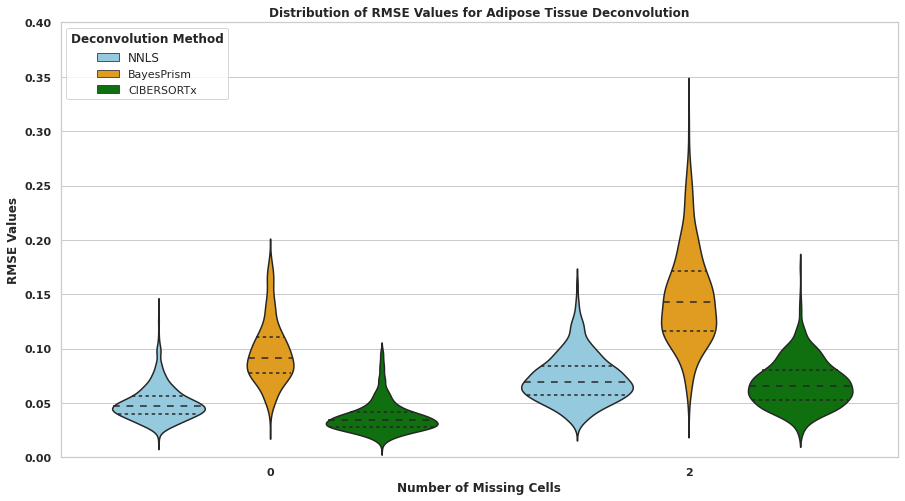

In [56]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create violin plots
plt.figure(figsize=(15, 8))

# Specify font properties
font_properties = {'family': 'Arial', 'weight': 'bold'}

# Create the violin plot
violin = sns.violinplot(x="num", y="value", hue="experiment", data=all_rmse.melt(id_vars=["num"], var_name="experiment", value_name="value"), 
                inner="quartile", palette=["skyblue", "orange", "green"], dodge=True)

# Set font properties for x-axis and y-axis
violin.set_xlabel("Number of Missing Cells", fontdict=font_properties)
violin.set_ylabel("RMSE Values", fontdict=font_properties)
violin.set_title("Distribution of RMSE Values for Adipose Tissue Deconvolution", fontdict=font_properties)
violin.set_ylim(0,0.4)
# Set font properties for legend
legend = violin.get_legend()
legend.set_title("Deconvolution Method", prop=font_properties)
legend.texts[0].set_fontsize(12)  # Set font size for legend items

# Set font properties for tick labels
violin.set_xticklabels(violin.get_xticklabels(), font_properties)
violin.set_yticklabels([f'{val:.2f}' for val in violin.get_yticks()], font_properties)  # Round y-axis values to 2 decimals

# Set legend location to upper left
legend._loc = 2
# Show the plot
plt.show()


In [57]:
# Separate data for each experimental condition
rmse_num_0 = all_rmse[all_rmse['num'] == 0]
rmse_num_2 = all_rmse[all_rmse['num'] == 2]

# Kruskal-Wallis test for each experimental condition
statistic_0, kw_p_value_0 = kruskal(rmse_num_0['NNLS'], rmse_num_0['BayesPrism'], rmse_num_0['CIBERSORTx'])
statistic_2, kw_p_value_2 = kruskal(rmse_num_2['NNLS'], rmse_num_2['BayesPrism'], rmse_num_2['CIBERSORTx'])

# Perform post-hoc Dunn's test if Kruskal-Wallis is significant
if kw_p_value_0 < 0.05:
    posthoc_0 = sph.posthoc_dunn([rmse_num_0['NNLS'], rmse_num_0['BayesPrism'], rmse_num_0['CIBERSORTx']])
    print('\nPost-hoc results for num=0:')
    print(posthoc_0)

if kw_p_value_2 < 0.05:
    posthoc_2 = sph.posthoc_dunn([rmse_num_2['NNLS'], rmse_num_2['BayesPrism'], rmse_num_2['CIBERSORTx']])
    print('\nPost-hoc results for num=2:')
    print(posthoc_2)



Post-hoc results for num=0:
               1              2             3
1   1.000000e+00  5.599511e-176  4.834925e-50
2  5.599511e-176   1.000000e+00  0.000000e+00
3   4.834925e-50   0.000000e+00  1.000000e+00

Post-hoc results for num=2:
               1              2              3
1   1.000000e+00  1.532057e-251   6.055636e-04
2  1.532057e-251   1.000000e+00  1.384467e-304
3   6.055636e-04  1.384467e-304   1.000000e+00
